In [ ]:
# Importing Packages

import spacy
nlp = spacy.load("en_core_web_sm")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, fbeta_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
import networkx as nx
import torch
!pip install transformers
!pip install lime
!pip install sacremoses
from transformers import AutoTokenizer, AutoModel, BioGptModel, AutoModelForSequenceClassification, AdamW, AutoModelForCausalLM, BioGptForCausalLM,GPT2ForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader, TensorDataset
import warnings
warnings.filterwarnings("ignore")
import gc
torch.cuda.empty_cache()
gc.collect()
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer
import sys

label_dict_small = {'Cardio/Pul': 0, 'Gastro': 1, 'Neuro': 2}

def get_components(term_matching):
    """
    Finds the connected components of a graph created from a dataframe containing two columns 'Term1' and 'Term2'.

    Args:
        term_matching (pandas.DataFrame): A dataframe containing two columns 'Term1' and 'Term2'.

    Returns:
        list: A list of connected components, where each component is a set of nodes.
    """
    if term_matching.empty:
        raise ValueError("Input dataframe is empty.")
    
    # Create an undirected graph from the dataframe
    graph = nx.Graph()
    graph.add_edges_from([(first, second) for first, second in zip(term_matching['Term1'], term_matching['Term2'])])

    # Find the connected components
    components = list(nx.connected_components(graph))

    return components


def get_plain_embedding_similarity(mod, model, tokenizer, term_matching, word_pairs):
    """
    Calculates the cosine similarity between the plain embeddings of the word pairs generated by a transformer model.

    Args:
        mod (str): The name of the transformer model.
        model (transformers.PreTrainedModel): The pre-trained transformer model.
        tokenizer (transformers.PreTrainedTokenizer): The pre-trained tokenizer used to tokenize the input words.
        term_matching (pandas.DataFrame): A dataframe containing two columns 'Term1' and 'Term2'.
        word_pairs (list): A list of tuples, where each tuple contains two words that form a pair.

    Returns:
        pandas.DataFrame: The input dataframe with an additional column 'mod_Cosine_Similarity' containing the cosine similarity scores.
    """

    # Generate Model embeddings for each word in the pair
    embeddings = []
    model.to('cpu')   # move model to CPU for faster inference
    for pair in word_pairs:
        inputs = tokenizer(pair, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings.append(outputs.hidden_states[-1].mean(dim=1).squeeze().numpy())  # get plain embedding for each word in the pair and store it

    # Compute the cosine similarity between Model embeddings for each pair
    similarities = [cosine_similarity([word[0],word[1]])[0][1] for word in embeddings]  # calculate cosine similarity score between embeddings of each pair
    term_matching[mod+'_Cosine_Similarity'] = similarities   # add the cosine similarity score to the input dataframe
    return term_matching  # return the updated dataframe

def preprocess(text):
    """
    Preprocesses input text by parsing it using spaCy, extracting named entities, replacing abbreviations,
    lemmatizing tokens, and removing stop words, punctuation, and spaces.

    Args:
        text (str): The input text to preprocess.

    Returns:
        pd.Series: A Pandas series containing the named entities from the original text, preprocessed text, and both.
    """
    # Use spaCy to parse the input text and extract named entities
    doc_raw = nlp(text)
    ner_raw = []
    for word in doc_raw.ents:
        ner_temp = [word.lemma_,word.label_]
        ner_raw.append(ner_temp)

    # Replace the abbreviation 'y/o' with 'year old'
    text = text.replace('y/o',' year old ')

    # Use spaCy to parse the text again and preprocess it
    doc = nlp(text)
    # Join the lemmatized tokens into a string, removing stop words, punctuation, and spaces
    text = " ".join([str(token.lemma_).strip().lower().replace(',','') for token in doc if token.is_stop == False and not token.is_punct and not token.is_space and len(str(token.lemma_).strip().lower()) >0])
    # Extract named entities from the preprocessed text
    ner_preprocess = []
    for word in doc.ents:
        ner_preprocess_temp = [word.lemma_,word.label_]
        ner_preprocess.append(ner_preprocess_temp)

    # Return the named entities from the original text, preprocessed text, and both
    return pd.Series([ner_raw,text,ner_preprocess])

def preprocess_notes(medical_notes, label_dict):
    """
    Preprocess medical notes data and try to capture NER tags.

    Args:
        medical_notes (pandas.DataFrame): The medical notes data to preprocess.
        label_dict (dict): A dictionary mapping category labels to numerical values.

    Returns:
        Tuple[pandas.DataFrame, dict]: A tuple containing the preprocessed medical notes data and the label dictionary.
    """
    print(medical_notes['category'].value_counts())
    medical_notes['category_label'] = medical_notes['category'].apply(lambda x: label_dict[x])
    medical_notes[['ner_notes','notes_preprocess','ner_preprocess_notes']] = medical_notes['notes'].apply(preprocess)
    return medical_notes, label_dict

def Analyze_models(model_dict, word_pairs, medical_notes, term_matching,label_dict):
    """
    Fine-tunes different models on medical notes data, evaluates their performance,
    and checks similarity between pairs of words using the models' embeddings.
    
    Args:
        model_dict (dict): A dictionary containing the names and pretrained models to use.
        word_pairs (list): A list of tuples of word pairs to compare for similarity.
        medical_notes (DataFrame): A pandas DataFrame containing medical notes data.
        term_matching (dict): A dictionary of terms and their embeddings to match for similarity. 
        label_dict (dict) : A dictionary of category and their numerical labels.
        
    Returns:
        Tuple: A tuple containing the medical notes DataFrame, the updated term_matching dictionary,
        and a dictionary of results for each model.
    """
    AllResult = {}
    path_models = './models/'
    if not os.path.exists(path_models):
        os.makedirs(path_models)
    # Load different Models and tokenizers
    for mod, value in model_dict.items():
        tokenizer = AutoTokenizer.from_pretrained(value['Tokenizer'])
        if mod == 'BioGPT':
            model = GPT2ForSequenceClassification.from_pretrained(
                value['Tokenizer'], num_labels=len(list(label_dict.keys())), output_hidden_states=True)
        else:
            model = AutoModelForSequenceClassification.from_pretrained(
                value['Model'], num_labels=len(list(label_dict.keys())), output_hidden_states=True)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        # Get direct embeddings from model and check similarity between pairs in term_matching
        term_matching = get_plain_embedding_similarity(
            mod, model, tokenizer, term_matching, word_pairs)
        print(mod+"_Raw")
        
        # Fine tune models on Raw notes data and get Performance Metrics
        result_scores, class_report, term_matching = fine_tune(
            mod, model, tokenizer, medical_notes, label_dict, 'notes', term_matching, word_pairs)
        AllResult[mod+'_Raw'] = {'Scores': result_scores, 'Report': class_report}

        # Reinitialize Tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(value['Tokenizer'])
        if mod == 'BioGPT':
            model = GPT2ForSequenceClassification.from_pretrained(
                value['Tokenizer'], num_labels=len(list(label_dict.keys())), output_hidden_states=True)
        else:
            model = AutoModelForSequenceClassification.from_pretrained(
                value['Model'], num_labels=len(list(label_dict.keys())), output_hidden_states=True)
        model.to(device)
        print('-'*100)
        print(mod+"_Preprocess")
        
        # Fine tune models on Preprocessed notes data and get Performance Metrics
        result_scores_preprocess, class_report_preprocess, term_matching = fine_tune(
            mod, model, tokenizer, medical_notes, label_dict, 'notes_preprocess', term_matching, word_pairs)
        AllResult[mod+'_Preprocess'] = {'Scores': result_scores_preprocess, 'Report': class_report_preprocess}
        print('#'*100)
    return medical_notes, term_matching, AllResult

def fine_tune(mod, model, tokenizer, medical_notes, label_dict,type_data,term_matching,word_pairs):
    """
    This function fine-tunes a given transformer model on a medical notes dataset, and returns performance metrics,
    term matching embedding similarity and saves the fine-tuned model, tokenizer and configuration, training and test files.

    Arguments:

        mod (string): Name of the transformer model to be fine-tuned.
        model (transformer model): Pre-trained transformer model to be fine-tuned.
        tokenizer (tokenizer): Pre-trained tokenizer corresponding to the model.
        medical_notes (pandas dataframe): Pandas dataframe containing the medical notes dataset.
        label_dict (dictionary): Dictionary mapping category labels to category names.
        type_data (string): Name of the column containing the text data in the medical_notes dataframe.
        term_matching (dictionary): Dictionary containing terms for term-matching analysis.
        word_pairs (list): List of tuples containing word pairs for term-matching analysis.
    Returns:

        result_scores (dictionary): Dictionary containing various performance metrics.
        class_report (string): String containing a classification report of the model.
        term_matching (dictionary): Dictionary containing term matching embeddings after fine-tuning.
"""
    # Define dataset
    class MyDataset(Dataset):
        def __init__(self, texts, labels, tokenizer):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            inputs = self.tokenizer.encode_plus(text, add_special_tokens=True, return_token_type_ids=False,
                                                padding='max_length', truncation=True, max_length=128)
            return {
                'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
                'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
                'labels': torch.tensor(label, dtype=torch.long)
            }

    # Splitting Between Dependent and Independent Variables
    data_X = medical_notes[[type_data]]
    data_Y = medical_notes[['category_label']]

    torch.cuda.empty_cache()
    random_seed = 12

    # Splitting data into test and train using sklearn stratified test_train_split
    X_train, X_test, y_train, y_test = train_test_split(data_X,data_Y,test_size=0.2, random_state=random_seed,stratify=data_Y)
    
    # Preparing Train_csv and Test_csv to store data and results for each models
    label_dict_map = {v:k for k,v in label_dict.items()}
    Train_csv = pd.concat([X_train,y_train],axis=1).reset_index(drop=True)
    Test_csv = pd.concat([X_test,y_test],axis=1).reset_index(drop=True)
    Train_csv['category'] = Train_csv['category_label'].apply(lambda x:label_dict_map[x])
    Test_csv['category'] = Test_csv['category_label'].apply(lambda x:label_dict_map[x])

    train_texts = list(X_train[type_data])
    train_labels = list(y_train['category_label'])

    test_texts = list(X_test[type_data])
    test_labels = list(y_test['category_label'])

    # Define optimizer and training settings
    optimizer = AdamW(model.parameters(), lr=2e-5)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Loading test and train data, varyying batch size and epochs for different models
    if mod == 'BioGPT':
        train_dataset = MyDataset(train_texts, train_labels, tokenizer)
        train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
        test_dataset = MyDataset(test_texts, test_labels, tokenizer)
        test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)
        model.resize_token_embeddings(len(tokenizer))
        model.lm_head = torch.nn.Linear(in_features=model.config.hidden_size, out_features=len(list(label_dict.keys())), bias=True)
        num_epochs = 10

    else:
        train_dataset = MyDataset(train_texts, train_labels, tokenizer)
        train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        test_dataset = MyDataset(test_texts, test_labels, tokenizer)
        test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
        num_epochs = 5

    # Fine-tune model  
    for epoch in range(num_epochs):
      model.train() 
      for batch in train_dataloader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)
          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()


          
    # Evaluate on test set
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, axis=1).tolist()
            predictions.extend(batch_predictions)

    Test_csv = pd.concat([Test_csv,pd.DataFrame(predictions,columns=['Prediction_label'])],axis=1)
    Test_csv['Prediction'] = Test_csv['Prediction_label'].apply(lambda x:label_dict_map[x])
    
    # Save all model results under given path
    output_path = "./models/"+mod+"_"+type_data+"/"
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Save Model, Config and Tokenizer, Traing and Test file
    model.save_pretrained(output_path)
    tokenizer.save_pretrained(output_path)
    model.config.to_json_file(output_path+"config.json")
    Train_csv.to_csv(output_path+'train_data.csv',index=False)
    Test_csv.to_csv(output_path+'test_predictions.csv',index=False)

    # return test_labels,predictions,label_dict
    result_scores,class_report = PerformanceMetrics(test_labels,predictions,label_dict,output_path)

    # Get term matching embedding after fine tuning
    term_matching = get_plain_embedding_similarity(mod+"_fine_tune_"+type_data,model,tokenizer,term_matching,word_pairs)


    return result_scores,class_report,term_matching


def get_score(y_ground, y_pred_ground, average='weighted'):
    """
    Calculates and returns the accuracy, precision, recall, and f1-score of the predicted labels.

    Parameters:
    y_ground (array-like): The ground truth labels.
    y_pred_ground (array-like): The predicted labels.
    average (string, optional): The averaging method for multi-class classification. Default is 'weighted'.

    Returns:
    Pandas DataFrame: A DataFrame containing the calculated scores with column names 'Accuracy', 'Precision', 'Recall', and 'F1-Score'.
    """
    score = [[round(accuracy_score(y_ground,y_pred_ground)*100.0,3),round(precision_score(y_ground,y_pred_ground,average=average)*100.0,3),round(recall_score(y_ground,y_pred_ground,average=average)*100.0,3),round(f1_score(y_ground,y_pred_ground,average=average)*100.0,3)]]
    return pd.DataFrame(score, columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

def PerformanceMetrics(y_ground, y_pred_ground, label_dict,output_path):
    """
    Calculates and prints the performance metrics, including accuracy, precision, recall, f1-score, confusion matrix, and classification report.

    Parameters:
    y_ground (array-like): The ground truth labels.
    y_pred_ground (array-like): The predicted labels.
    label_dict (dict): A dictionary containing the label names as keys and their corresponding integer values as values.
    output_path (str): Model Specific Path to save confusion matrix
    Returns:
    tuple: A tuple containing the result_scores and classification_report_df DataFrames.
    """
    # Get the performance metrics scores
    result_scores = get_score(y_ground, y_pred_ground)

    # Print the scores
    print(result_scores.head(10))

    # Get and print the confusion matrix
    get_confusion(y_ground, y_pred_ground, label_dict, output_path, sample_weight=None, normalize=None, xlab="Predicted Label", ylab="Actual Label")

    # Get the classification report
    report = classification_report(y_ground, y_pred_ground, target_names=list(label_dict.keys()), output_dict=True)

    # Create a DataFrame from the classification report
    classification_report_df = pd.DataFrame(report).transpose()

    # Print the classification report
    print(classification_report_df.head(10))

    # Return the DataFrames
    return result_scores, classification_report_df


def get_confusion(y_ground, y_pred_ground, label_dict, output_path,sample_weight=None, normalize=None, xlab="Predicted Label", ylab="Actual Label"):
    """
    Plot and saves the confusion matrix for the given ground truth and predicted labels.

    Args:
    - y_ground: array-like of shape (n_samples,), true labels for samples.
    - y_pred_ground: array-like of shape (n_samples,), predicted labels for samples.
    - label_dict: dict, a dictionary of label names and their corresponding indices in the confusion matrix.
    - sample_weight: array-like of shape (n_samples,), optional, Sample weights.
    - normalize: str or None, optional, 'true', 'pred', 'all', Normalize confusion matrix over the true (rows), predicted (columns) or all population. If None, confusion matrix will not be normalized.
    - xlab: str, optional, the label for the x-axis of the confusion matrix plot.
    - ylab: str, optional, the label for the y-axis of the confusion matrix plot.
    - output_path (str): Model Specific Path to save confusion matrix

    Returns:
    - None

    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_ground, y_pred_ground, sample_weight=sample_weight, normalize=normalize)
    
    # Set the font size and figure size of the plot
    plt.rcParams.update({'font.size': 15})
    plt.rcParams.update({'figure.figsize':(10,10)})
    
    # Plot the heatmap of the confusion matrix using seaborn
    heatmap = sns.heatmap(cm, xticklabels=list(label_dict.keys()), yticklabels=list(label_dict.keys()), square=True, cmap="YlGnBu", annot=True, fmt='g', annot_kws={"fontsize": 12})
    
    # Set the x and y labels of the plot
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title("Confusion Matrix (Actual vs Predicted)")
    
    # Show the plot
    plt.plot()
    plt.xticks(rotation = 30)
    plt.savefig(output_path+'confusion_matrix.png', bbox_inches = 'tight')
    plt.show()

def lime_prediction(model_name, text, save_path,label_dict_small, output_label = tuple(label_dict_small.values()), num_features=10, num_samples = 20):
    """
    Generate an explanation for a given text using LIME.

    Args:
        model_name (str): The name of the model to use for prediction.
        text (str): The input text to generate an explanation for.
        save_path (str): The path to save the LIME explanation to.
        label_dict_small (dict): A dictionary mapping label names to integer ids.
        output_label (tuple, optional): A tuple of label ids to generate explanations for. Defaults to all labels.
        num_features (int, optional): The number of features to include in the explanation. Defaults to 10.
        num_samples (int, optional): The number of samples to generate for each explanation. Defaults to 20.

    Returns:
        None
    """
    # Define the predictor function for LIME
    def predictor(texts):
        # Free up GPU memory and run garbage collection
        torch.cuda.empty_cache()
        gc.collect()

        # Set up the device and move the model to the GPU
        device = torch.device("cuda")
        torch.cuda.empty_cache()
        model.to(device)

        # Tokenize the input text and move it to the GPU
        input = tokenizer(texts, return_tensors="pt", padding=True)
        input.to(device)

        # Run the model and convert the logits to probabilities
        outputs = model(**input)
        tensor_logits = outputs[0]
        probas = F.softmax(tensor_logits.cpu()).detach().numpy()
        return probas

    # Load the model and tokenizer
    class_names = list(label_dict_small.keys())
    filename_model = './models/'+model_name
    tokenizer = AutoTokenizer.from_pretrained(filename_model)
    model = AutoModelForSequenceClassification.from_pretrained(filename_model)

    # Free up GPU memory and run garbage collection
    torch.cuda.empty_cache()
    gc.collect()

    # Set up the LIME explainer and generate the explanation
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(text, predictor, num_features=num_features, num_samples=num_samples, labels=output_label)

    # Display the explanation in the notebook and save it to a file
    exp.show_in_notebook(text=True, labels=output_label)
    exp.save_to_file(save_path)







Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=a571e98e2e730611421303483cfc08511fcb50c192a6727f8e290eedfdfea6e7
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 54

In [ ]:
!unzip '/content/MedicalNotesNLPChallenge.zip' -d /content/MedicalNotesNLPChallenge/

Archive:  /content/MedicalNotesNLPChallenge.zip
  inflating: /content/MedicalNotesNLPChallenge/Problem statement.docx  
  inflating: /content/MedicalNotesNLPChallenge/__MACOSX/._Problem statement.docx  
  inflating: /content/MedicalNotesNLPChallenge/ClinNotes.csv  
  inflating: /content/MedicalNotesNLPChallenge/__MACOSX/._ClinNotes.csv  
  inflating: /content/MedicalNotesNLPChallenge/MedicalConcepts.csv  
  inflating: /content/MedicalNotesNLPChallenge/__MACOSX/._MedicalConcepts.csv  


(566, 2)
(818, 2)
(558, 2)
14
[{'Bedwetting', 'Adenitis', 'Gastroenteritis', 'Vertigo', 'Amantadine', 'Colchicine', 'Spiriva', 'Coumadin', 'Nocturia', 'Histoplasmosis', 'Tamiflu', 'Pyorrhea', 'Ceftiaxone', 'Mycosis', 'Glaucoma', 'Carboplatin', 'Hyperacusis', 'Seasickness', 'Osteoporosis', 'Dizziness', 'Cluttering', 'Lopid', 'Mannitol', 'Chloramphenicol', 'Silvadene', 'Famvir', 'Wellbutrin', 'Lisinopril', 'Headache', 'Amoxil', 'Cardiomyopathies', 'Arthritis', 'Ketonuria', 'Lipitor', 'Angina', 'Acne', 'Cholestyramine', 'Scleroderma', 'Zithromax', 'Tiredness', 'Ethanol', 'Robitussin', 'Allopurinol', 'Malaria', 'Thirsty', 'Haemorrhoids', 'Epilepsy', 'Dyspnea', 'Amenorrhoea', 'Alcohol', 'Protamine Sulfate', 'Hemiplegia', 'Toprol-XR', 'Heartburn', 'Myopathy', 'Dysuria', 'Anosmia', 'Prilosec', 'Rogaine', 'Vitamin K', 'Rabies', 'Nystagmus', 'Bacitracin', 'Cardialgia', 'Pallor', 'Overnutrition', 'Parasitemia', 'Syphilis', 'Hemoglobinopathy', 'Opisthotonus', 'Cefazolin', 'Calamine', 'Constipatio

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

BioBERT_Raw
   Accuracy  Precision  Recall  F1-Score
0    97.561     97.561  97.561    97.561


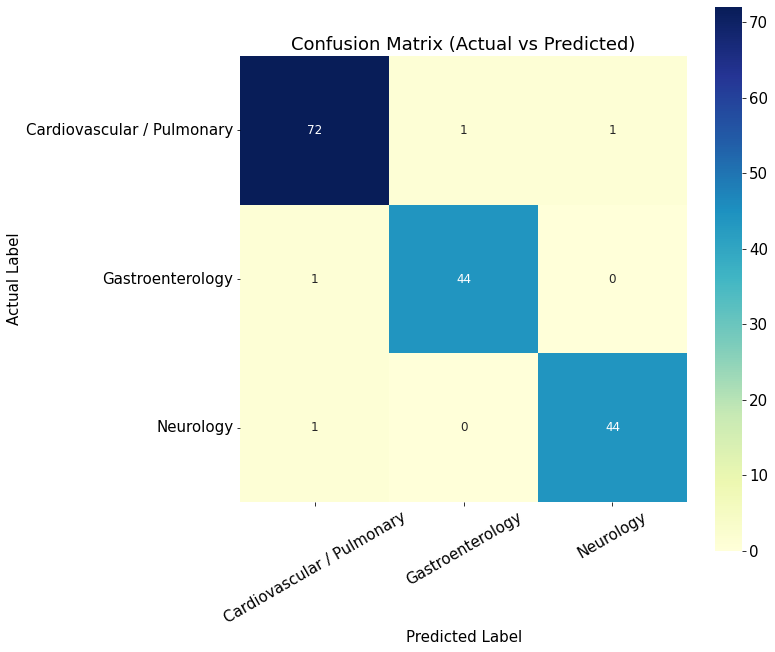

                            precision    recall  f1-score    support
Cardiovascular / Pulmonary   0.972973  0.972973  0.972973   74.00000
Gastroenterology             0.977778  0.977778  0.977778   45.00000
Neurology                    0.977778  0.977778  0.977778   45.00000
accuracy                     0.975610  0.975610  0.975610    0.97561
macro avg                    0.976176  0.976176  0.976176  164.00000
weighted avg                 0.975610  0.975610  0.975610  164.00000


Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

----------------------------------------------------------------------------------------------------
BioBERT_Preprocess
   Accuracy  Precision  Recall  F1-Score
0    97.561     97.561  97.561    97.561


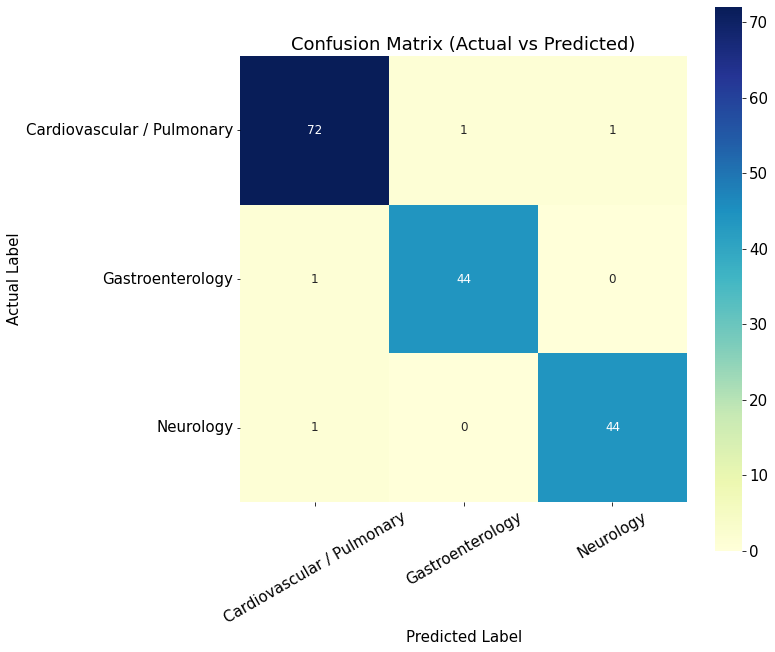

                            precision    recall  f1-score    support
Cardiovascular / Pulmonary   0.972973  0.972973  0.972973   74.00000
Gastroenterology             0.977778  0.977778  0.977778   45.00000
Neurology                    0.977778  0.977778  0.977778   45.00000
accuracy                     0.975610  0.975610  0.975610    0.97561
macro avg                    0.976176  0.976176  0.976176  164.00000
weighted avg                 0.975610  0.975610  0.975610  164.00000


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


####################################################################################################


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

ClinicalBERT_Raw
   Accuracy  Precision  Recall  F1-Score
0    96.951     96.961  96.951    96.951


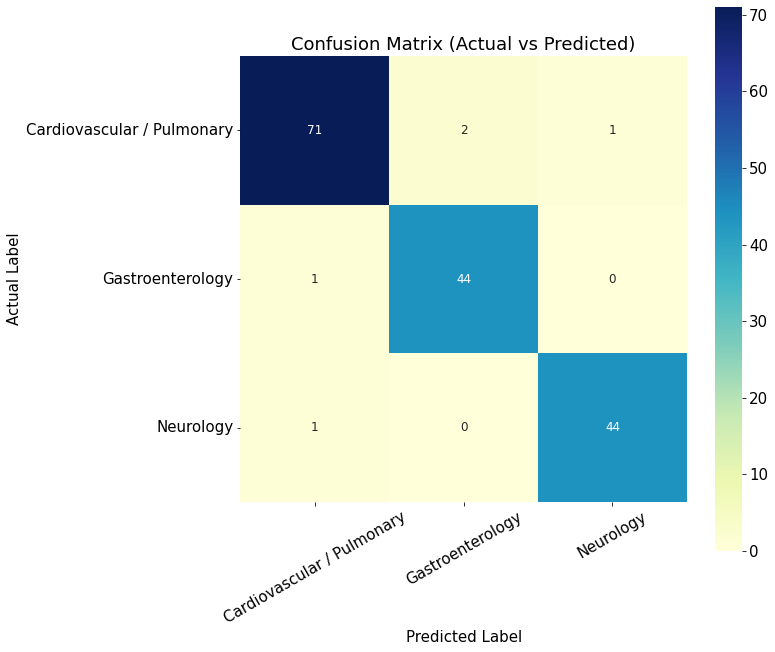

                            precision    recall  f1-score     support
Cardiovascular / Pulmonary   0.972603  0.959459  0.965986   74.000000
Gastroenterology             0.956522  0.977778  0.967033   45.000000
Neurology                    0.977778  0.977778  0.977778   45.000000
accuracy                     0.969512  0.969512  0.969512    0.969512
macro avg                    0.968967  0.971672  0.970266  164.000000
weighted avg                 0.969610  0.969512  0.969509  164.000000


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

----------------------------------------------------------------------------------------------------
ClinicalBERT_Preprocess
   Accuracy  Precision  Recall  F1-Score
0    97.561     97.561  97.561    97.561


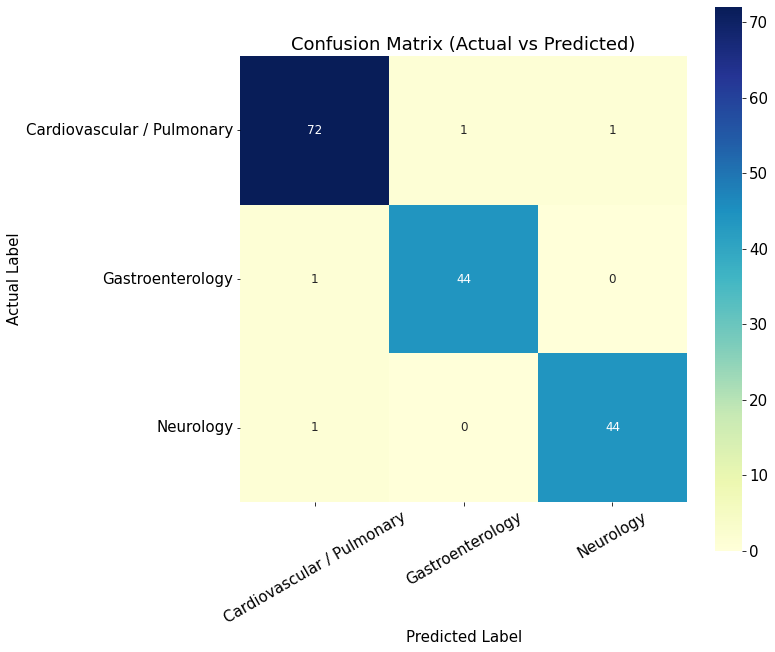

                            precision    recall  f1-score    support
Cardiovascular / Pulmonary   0.972973  0.972973  0.972973   74.00000
Gastroenterology             0.977778  0.977778  0.977778   45.00000
Neurology                    0.977778  0.977778  0.977778   45.00000
accuracy                     0.975610  0.975610  0.975610    0.97561
macro avg                    0.976176  0.976176  0.976176  164.00000
weighted avg                 0.975610  0.975610  0.975610  164.00000


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


####################################################################################################


Some weights of the model checkpoint at bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceCla

BlueBERT_Raw
   Accuracy  Precision  Recall  F1-Score
0    96.951     96.961  96.951    96.951


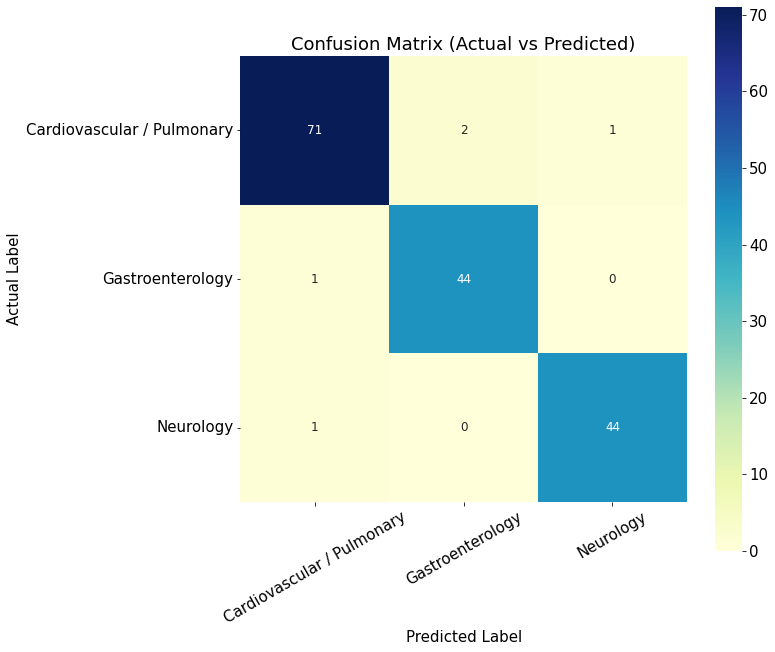

                            precision    recall  f1-score     support
Cardiovascular / Pulmonary   0.972603  0.959459  0.965986   74.000000
Gastroenterology             0.956522  0.977778  0.967033   45.000000
Neurology                    0.977778  0.977778  0.977778   45.000000
accuracy                     0.969512  0.969512  0.969512    0.969512
macro avg                    0.968967  0.971672  0.970266  164.000000
weighted avg                 0.969610  0.969512  0.969509  164.000000


Some weights of the model checkpoint at bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceCla

----------------------------------------------------------------------------------------------------
BlueBERT_Preprocess
   Accuracy  Precision  Recall  F1-Score
0    96.951     96.964  96.951    96.951


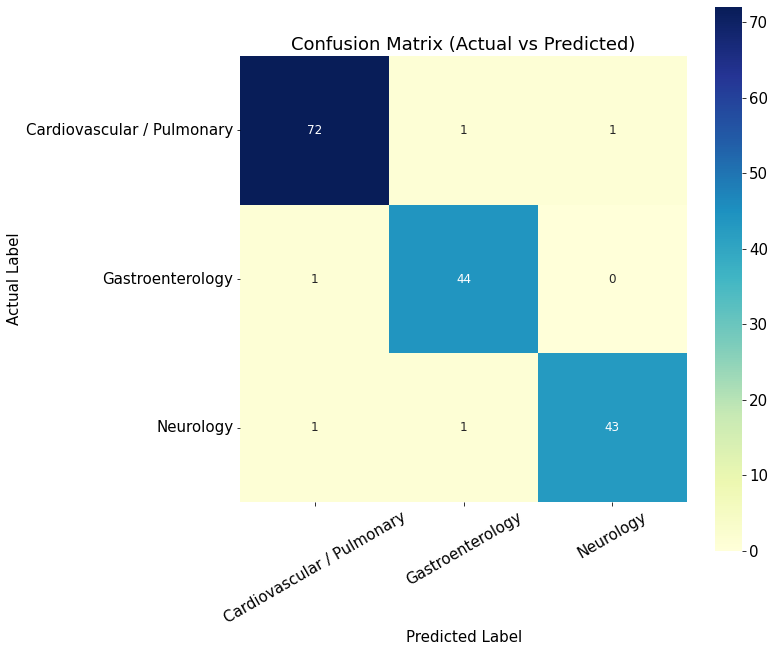

                            precision    recall  f1-score     support
Cardiovascular / Pulmonary   0.972973  0.972973  0.972973   74.000000
Gastroenterology             0.956522  0.977778  0.967033   45.000000
Neurology                    0.977273  0.955556  0.966292   45.000000
accuracy                     0.969512  0.969512  0.969512    0.969512
macro avg                    0.968922  0.968769  0.968766  164.000000
weighted avg                 0.969639  0.969512  0.969510  164.000000


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


####################################################################################################


You are using a model of type biogpt to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at microsoft/biogpt were not used when initializing GPT2ForSequenceClassification: ['biogpt.layers.6.final_layer_norm.weight', 'biogpt.layers.0.self_attn.q_proj.weight', 'biogpt.layers.9.final_layer_norm.weight', 'biogpt.layers.17.self_attn.k_proj.weight', 'biogpt.layers.6.self_attn.q_proj.bias', 'biogpt.layers.13.self_attn.v_proj.bias', 'biogpt.layers.21.fc1.weight', 'biogpt.layers.14.fc1.bias', 'biogpt.layers.8.self_attn.q_proj.bias', 'biogpt.layers.8.fc2.bias', 'biogpt.layers.18.final_layer_norm.bias', 'biogpt.layers.12.self_attn_layer_norm.weight', 'biogpt.layers.9.self_attn.v_proj.bias', 'biogpt.layers.11.fc1.weight', 'biogpt.layers.14.self_attn.out_proj.bias', 'biogpt.layers.23.final_layer_norm.weight', 'biogpt.layers.19.fc1.bias', 'biogpt.layers.19.final_layer_norm.weight', 'biogpt.layers.8.final_layer_norm.weight', 'biogpt.layers.22.fc1.weight', 'biogpt.layers.8.final_layer_norm.bias', 'biogpt.layers.20.self_attn.k_proj.bias', 'biogpt.layers

BioGPT_Raw
   Accuracy  Precision  Recall  F1-Score
0    87.195     87.692  87.195    87.234


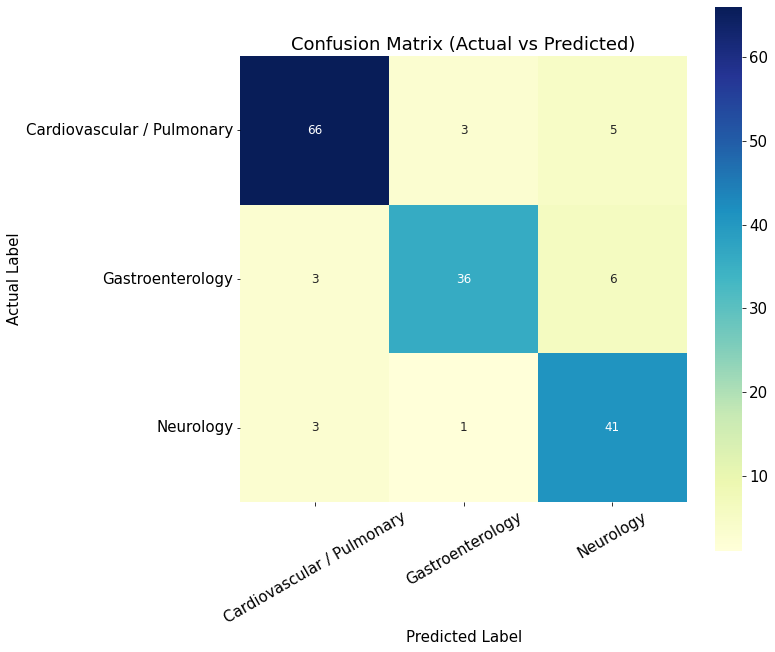

                            precision    recall  f1-score     support
Cardiovascular / Pulmonary   0.916667  0.891892  0.904110   74.000000
Gastroenterology             0.900000  0.800000  0.847059   45.000000
Neurology                    0.788462  0.911111  0.845361   45.000000
accuracy                     0.871951  0.871951  0.871951    0.871951
macro avg                    0.868376  0.867668  0.865510  164.000000
weighted avg                 0.876915  0.871951  0.872335  164.000000


You are using a model of type biogpt to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/biogpt were not used when initializing GPT2ForSequenceClassification: ['biogpt.layers.6.final_layer_norm.weight', 'biogpt.layers.0.self_attn.q_proj.weight', 'biogpt.layers.9.final_layer_norm.weight', 'biogpt.layers.17.self_attn.k_proj.weight', 'biogpt.layers.6.self_attn.q_proj.bias', 'biogpt.layers.13.self_attn.v_proj.bias', 'biogpt.layers.21.fc1.weight', 'biogpt.layers.14.fc1.bias', 'biogpt.layers.8.self_attn.q_proj.bias', 'biogpt.layers.8.fc2.bias', 'biogpt.layers.18.final_layer_norm.bias', 'biogpt.layers.12.self_attn_layer_norm.weight', 'biogpt.layers.9.self_attn.v_proj.bias', 'biogpt.layers.11.fc1.weight', 'biogpt.layers.14.self_attn.out_proj.bias', 'biogpt.layers.23.final_layer_norm.weight', 'biogpt.layers.19.fc1.bias', 'biogpt.layers.19.final_layer_norm.weight', 'biogpt.layers.8.fin

----------------------------------------------------------------------------------------------------
BioGPT_Preprocess
   Accuracy  Precision  Recall  F1-Score
0    93.902     94.059  93.902    93.859


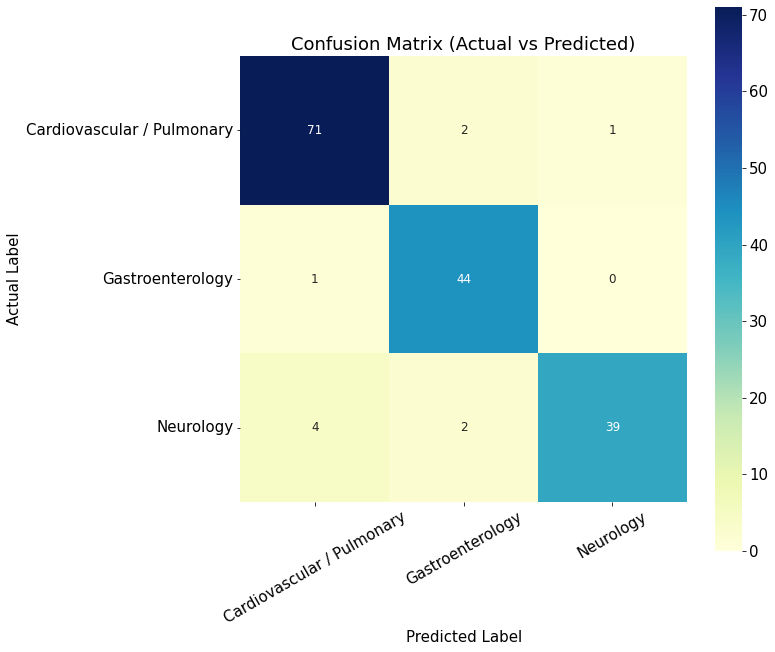

                            precision    recall  f1-score     support
Cardiovascular / Pulmonary   0.934211  0.959459  0.946667   74.000000
Gastroenterology             0.916667  0.977778  0.946237   45.000000
Neurology                    0.975000  0.866667  0.917647   45.000000
accuracy                     0.939024  0.939024  0.939024    0.939024
macro avg                    0.941959  0.934635  0.936850  164.000000
weighted avg                 0.940589  0.939024  0.938586  164.000000
####################################################################################################


In [ ]:
term_matching = pd.read_csv('./MedicalNotesNLPChallenge/MedicalConcepts.csv')
medical_notes = pd.read_csv('./MedicalNotesNLPChallenge/ClinNotes.csv')
print(term_matching.shape)
print(medical_notes.shape)


term_matching = term_matching.drop_duplicates().reset_index(drop=True)
print(term_matching.shape)

components = get_components(term_matching)
print(len(components))
print(components)

word_pairs = [(first,second) for first,second in zip(term_matching['Term1'],term_matching['Term2'])]



model_dict={'BioBERT':{'Model':'dmis-lab/biobert-base-cased-v1.1','Tokenizer':'dmis-lab/biobert-base-cased-v1.1'},
            'ClinicalBERT':{'Model':'emilyalsentzer/Bio_ClinicalBERT','Tokenizer':'emilyalsentzer/Bio_ClinicalBERT'}, 
            'BlueBERT':{'Model':'bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12','Tokenizer':'bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12'}, 
            'BioGPT':{'Model':'microsoft/biogpt','Tokenizer':'microsoft/biogpt'}
            }

label_dict = {'Cardiovascular / Pulmonary':0,'Gastroenterology':1,'Neurology':2}

medical_notes,label_dict = preprocess_notes(medical_notes,label_dict)


medical_notes, term_matching, AllResult = Analyze_models(model_dict,word_pairs,medical_notes,term_matching,label_dict)



term_matching.to_csv('term_matching.csv', index=False)
medical_notes.to_csv('medical_notes.csv',index=False)

with open('AllResult.pickle', 'wb') as handle:
    pickle.dump(AllResult, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
texts = ["clinical indication chest pain interpretation patient receive 14.9 mci cardiolite rest portion study 11.5 mci cardiolite stress portion study the patient baseline ekg normal sinus rhythm patient stress accord bruce protocol dr. x. exercise test supervise interpret dr. x. separate report stress portion study the myocardial perfusion spect study show mild anteroseptal fix defect see likely secondary soft tissue attenuation artifact mild partially reversible perfusion defect see pronounced stress image short axis view suggestive minimal ischemia inferolateral wall the gate spect study show normal wall motion wall thickening calculate leave ventricular ejection fraction 59%.conclusion:1 exercise myocardial perfusion study show possibility mild ischemia inferolateral wall 2 normal lv systolic function lv ejection fraction 59",
         "preoperative diagnosis abdominal mass postoperative diagnosis abdominal mass procedure paracentesis description procedure 64 year old female stage ii endometrial carcinoma resect treat chemotherapy radiation present time patient radiation treatment week ago develop large abdominal mass cystic nature radiologist insert pigtail catheter emergency room proceed admit patient drain significant clear fluid subsequent day cytology fluid negative culture negative eventually patient send home pigtail shut patient week later undergo repeat cat scan abdoman pelvis the cat scan show accumulation fluid mass achieve 80 previous size call patient home come emergency department service provide time proceed work pigtail catheter obtain informed consent prepare drape area usual fashion unfortunately catheter open drainage system time withdraw directly syringe 700 ml clear fluid system connect drain bag patient instruct log use equipment give appointment office monday day",
         "technique sequential axial ct image obtain cervical spine contrast additional high resolution coronal sagittal reconstruct image obtain well visualization osseous structure findings cervical spine demonstrate normal alignment mineralization evidence fracture dislocation spondylolisthesis vertebral body height disc space maintain central canal patent pedicle posterior element intact paravertebral soft tissue normal limit atlanto den interval den intact visualized lung apex clear impression acute abnormality"
        ]
correct_labels = [0,1,2]
saved_models_raw = ['BioBERT_notes','ClinicalBERT_notes','BlueBERT_notes','BioGPT_notes']
saved_models_preprocess = ['BioBERT_notes_preprocess','ClinicalBERT_notes_preprocess','BlueBERT_notes_preprocess','BioGPT_notes_preprocess']


model_name = 'ClinicalBERT_notes_preprocess'
num = 2
save_path = './lime/'+model_name+"_"+str(num)+".html"
if not os.path.exists('./lime/'):
        os.makedirs('./lime/')
lime_prediction(model_name, texts[num], save_path,label_dict_small, output_label = (correct_labels[num],), num_features=6, num_samples = 50)

In [118]:
complete_list = ' '.join(list(medical_notes['notes'])).lower().split(' ')


In [119]:
len(complete_list)

373370

In [120]:
unique_words = list(set(complete_list))
len(unique_words)

32553

In [121]:
unique_terms = list(set().union(*components))


In [124]:
term_counts = []
total_counts = 0
for term in unique_terms:
  cnt = complete_list.count(term.lower())
  total_counts = total_counts + cnt
  term_counts.append([term,cnt])

In [125]:
print(total_counts)
term_counts

2255


[['Bedwetting', 0],
 ['Adenitis', 0],
 ['Bleomycin', 0],
 ['Aspirin', 52],
 ['Gastroenteritis', 0],
 ['Toothache', 0],
 ['Digoxin', 8],
 ['Prostatism', 0],
 ['Vertigo', 8],
 ['Cirrhosis', 11],
 ['Amantadine', 0],
 ['Colchicine', 0],
 ['Spiriva', 5],
 ['Coumadin', 44],
 ['Nocturia', 2],
 ['Amyloidoses', 0],
 ['Histoplasmosis', 2],
 ['Tamiflu', 0],
 ['Bactroban', 0],
 ['Pyorrhea', 1],
 ['Ceftiaxone', 0],
 ['Mastodynia', 0],
 ['Polyarthritides', 0],
 ['Mycosis', 0],
 ['Vermox', 0],
 ['Meningitis', 1],
 ['Duragesic', 1],
 ['Glaucoma', 0],
 ['Narcan', 2],
 ['Carboplatin', 0],
 ['Hyperacusis', 0],
 ['Seasickness', 0],
 ['Anoxemia', 0],
 ['Osteoporosis', 1],
 ['Dizziness', 13],
 ['comatose', 0],
 ['Hyperesthesia', 1],
 ['Dementia', 19],
 ['Cluttering', 0],
 ['Coccidioses', 0],
 ['Activase', 1],
 ['Lopid', 0],
 ['Mannitol', 5],
 ['Chloramphenicol', 0],
 ['Cachexia', 0],
 ['Silvadene', 0],
 ['Vfend', 0],
 ['Hemicrania', 0],
 ['Deafness', 0],
 ['Arteriosclerosis', 0],
 ['Famvir', 0],
 ['Myositis